In [129]:
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import optuna
import scipy.io
import os, random
from clearml import Task
from scipy.sparse import csr_matrix

seed = 42

def seed_everything(seed):
    print("Seeding...")
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    print("Seeded everything!")

def add_to_class(Class):
    """Register functions as methods in created class."""
    def wrapper(obj):
        setattr(Class, obj.__name__, obj)
    return wrapper

In [263]:
import scipy.sparse


class HDDA:

    def __init__(self, X, r, y_true=None, precision=2, task_name='BCD', debug=True):
        self.precision = precision

        if isinstance(X, str):
            X = scipy.io.loadmat(X)['X']
        elif isinstance(X, np.ndarray) and np.isnan(X).any(): 
            # then impute np.nan with zeros
            X = np.nan_to_num(X, nan=0)
          
         # Model parameters
        self.m, self.n = X.shape  # dimensions of X
        self.r = r
        self.X  = csr_matrix(X)
        self.W = self.X.copy()
        self.W.data = np.ones_like(self.W.data)

        if y_true:
            self.val = pd.read_csv(y_true, header=None)
            self.val.columns = ['user', 'movie', 'true']

        self.debug = debug
        if not debug:
            self.task = Task.init(project_name='HDDA', 
                                task_name=task_name,
                                auto_connect_frameworks=False,
                                auto_resource_monitoring=False,
                                reuse_last_task_id=False)
            self.logger = Task.get_logger(self.task)
       
    def init_UV(self, strategy='eye'):
        '''Initialize matrices U and V with eye matrix (or random values)'''
        self.UV_strategy = strategy
        match strategy:
            case 'eye':
                self.U = np.eye(self.m, self.r)
                self.V = np.eye(self.n, self.r)
            case 'random':
                self.U = np.random.rand(self.m, self.r)
                self.V = np.random.rand(self.n, self.r) * 4 + 1

    def calc_errors_matrix(self, U, V):
        residual = U @ V.T  # reconstructed matrix
        masked_residual = self.W.multiply(self.X - residual)  # error only for known values
        return masked_residual

    # Function to calculate the weighted loss
    @staticmethod
    def rmse(error):
        """Calculate root mean squared error (RMSE) loss."""
        if isinstance(error, np.ndarray):
            return np.sqrt(np.mean((error**2)))
        else:
            return np.sqrt(error.power(2).mean())
    
    def log_metrics(self, U, V, idx, log_step, max_iter, prev_loss, tol):
        # Compute training error
        train_loss = HDDA.rmse(self.calc_errors_matrix(U, V))
        if not self.debug:
            # Log and print progress
            self.logger.report_scalar('loss', 'train', train_loss, idx)
        val_loss = np.inf
        if idx % log_step == 0 or idx == max_iter - 1:
            print(f"Iteration {idx + 1}: Training Loss = {train_loss:.4f}")
            if hasattr(self, 'val'):
                self.predicted_X = self.predict(U, V)
                self.val['predicted'] = self.predicted_X[self.val.iloc[:, 0] - 1, 
                                                         self.val.iloc[:, 1] - 1]
                val_loss = HDDA.rmse(np.asarray(self.val['predicted'] - self.val['true']))
                if not self.debug:
                    self.logger.report_scalar('loss', 'val', val_loss, idx)
                print(f"Validation RMSE: {val_loss:.4f}")

        # Check convergence
        if abs(prev_loss - train_loss) < tol:
            print(f"Converged at iteration {idx + 1}")
            print(f"Training Loss = {train_loss:.4f}")
            if hasattr(self, 'val'):
                print(f"Validation RMSE: {val_loss:.4f}")
            return True, train_loss, val_loss
        else: return False, train_loss, val_loss
        
    
    def predict(self, U, V):
        return np.round(U @ V.T, self.precision)
    

    def test(self, path='./inputEval.mat', predicts_path='predicts.csv'):
        res = scipy.io.loadmat(path)
        print(res['Eval'].shape)
        test_predicts = self.predicted_X[res['Eval'][:,0]- 1, 
                                         res['Eval'][:,1] - 1]
        print(test_predicts.shape)
        self.test_predicts = pd.Series(data=test_predicts, 
                                       index=range(1, test_predicts.shape[0]+1))
        self.test_predicts.to_csv(predicts_path, index_label='ID', header=['Rating'])
        return self.test_predicts
    
    
    def show_error_heatmap(self, scale=10):
        errors_matrix = self.calc_errors_matrix(self.U, self.V)
        errors_matrix = abs(errors_matrix.toarray()[:scale,:scale])
        mask = self.W.toarray()[:scale,:scale].astype(bool)
        sns.heatmap(errors_matrix, 
                    annot=True, vmin=0, vmax=5, 
                    mask=~mask).set_title('Errors Heatmap')
        if not self.debug:
            self.logger.report_confusion_matrix('Errors Heatmap', 'series', errors_matrix, iteration=1)

# Nonnegative Matrix Factorization (NMF)

The **Multiplicative Update (MU)** algorithm iteratively updates $( W )$ and $( H )$ by minimizing the reconstruction error:
$[
\min_{W, H} || X - WH ||_F^2
]$
subject to $( W \geq 0 )$ and $( H \geq 0 )$. Here, $( || \cdot ||_F )$ denotes the Frobenius norm.

#### Update Equations

The MU algorithm applies the following element-wise update rules for $( W )$ and $( H )$:

1. **Update for $( H )$**:
   $[
   H \leftarrow H \circ \frac{W^T X}{W^T WH}
   ]$

2. **Update for $( W )$**:
   $[
   W \leftarrow W \circ \frac{X H^T}{W H H^T}
   ]$
   
where $( \circ )$ denotes element-wise multiplication, and division is also element-wise.


In [94]:
@add_to_class(HDDA)
def NMF(self, max_iter=100, log_step=2, tol=1e-6):
    """
    Performs Nonnegative Matrix Factorization using the Multiplicative Update algorithm.
    
    Parameters:
        max_iter (int): The maximum number of iterations.
        tol (float): The tolerance for convergence.
    """
    self.task.connect(dict(max_iter=max_iter, 
                           latency_factors=self.r, 
                           UV_init_strategy=self.UV_strategy))
    logger = Task.get_logger(self.task)

    train_losses = []
    val_losses = []
    prev_error = np.inf

    for idx in tqdm(range(max_iter), desc='Training'):
        # Update V by fixing U
        self.V = self.V * ((self.U.T @ self.X)/(self.U.T @ self.U @ self.V + 1e-10))
        # Update U by fixing V
        self.U = self.U * ((self.X @ self.V.T)/(self.U @ self.V @ self.V.T + 1e-10))
        
        loss = np.linalg.norm(self.calc_errors_matrix(self.U, self.V), 'fro')
        logger.report_scalar('loss', 'train', loss, idx)
        
        if idx % log_step == 0:
            train_losses.append(loss)
            print(f"Iteration {idx}: Loss = {loss:.4f}")
            
            self.predicted_X = self.predict(self.U, self.V) # Final predicted preference matrix
            if hasattr(self, 'val'):
                self.val['predicted'] = self.predicted_X[self.val.iloc[:,0]  - 1, 
                                                         self.val.iloc[:,1] - 1]
                val_loss = HDDA.rmse(np.asarray(self.val['predicted'] - self.val['true']))
                val_losses.append(val_loss)
                logger.report_scalar('loss', 'val', val_loss, idx)

                print("RMSE on val: ", val_loss, '\n')
            if (prev_error-loss) < tol:
                print("Converged.")
                break
            prev_error = loss
        if np.isnan(loss):
            print("LOSS: ", loss)
            break
    if hasattr(self, 'val'):
        logger.report_single_value('loss/val', val_loss)
        self.finish_val_loss = val_loss

    return self.predicted_X

In [95]:
test_NMF_method = HDDA(X=np.array([
                    [2, 3, 2, np.nan, np.nan],
                    [np.nan, 2, np.nan, 4, 3],
                    [3, np.nan, 3, np.nan, 4],
                    [np.nan, 3, np.nan, 4, 3],
                    [np.nan, np.nan, np.nan, np.nan, 2],
                    [1, 4, 3, 4, np.nan],
                    [5, 3, 2, np.nan, np.nan]]),
                r=2, task_name='test_NMF'
    )
test_NMF_method.init_UV('random')
test_NMF_method.NMF(max_iter=10000, log_step=100, tol=1e-10)
test_NMF_method.show_error_heatmap(max(test_NMF_method.m, test_NMF_method.n))
test_NMF_method.task.close()

ValueError: unrecognized csr_matrix constructor input: [[ 2.  3.  2. nan nan]
 [nan  2. nan  4.  3.]
 [ 3. nan  3. nan  4.]
 [nan  3. nan  4.  3.]
 [nan nan nan nan  2.]
 [ 1.  4.  3.  4. nan]
 [ 5.  3.  2. nan nan]]

In [4]:
configs = dict(max_iter=100000, r=15)

kaggle_NMF = HDDA(X='./inputX.mat', r=configs['r'], y_true='./ratings_given.csv', task_name='kaggle_NMF_fix')
kaggle_NMF.init_UV('random')

kaggle_NMF.NMF(max_iter=configs['max_iter'], log_step=100, tol=1e-5)
kaggle_NMF.show_error_heatmap(15)

predicts_path = 'predicts_NMF.csv'
kaggle_NMF.test(path='./inputEval.mat', predicts_path=predicts_path)
kaggle_NMF.task.close()

ClearML Task: created new task id=5586b7abfe9d4660905e45e02dc3bcb3
2024-11-19 15:06:02,976 - clearml.Task - INFO - Storing jupyter notebook directly as code
ClearML results page: https://app.clear.ml/projects/520a519c5b09413f9400a52e9dbf3d61/experiments/5586b7abfe9d4660905e45e02dc3bcb3/output/log


 ... (more hidden) ...

Iteration 0: Loss = 1066.6884
RMSE on val:  1.1924690522451649 



 ... (more hidden) ...

Iteration 100: Loss = 1049.8101
RMSE on val:  1.1736064719160788 



 ... (more hidden) ...

Iteration 200: Loss = 1046.3211
RMSE on val:  1.1697031268616631 



 ... (more hidden) ...

Iteration 300: Loss = 1036.3303
RMSE on val:  1.1585365387736153 



 ... (more hidden) ...

Iteration 400: Loss = 1022.8472
RMSE on val:  1.1434573696584374 



 ... (more hidden) ...

Iteration 500: Loss = 1014.7271
RMSE on val:  1.134384191357295 



 ... (more hidden) ...

Iteration 600: Loss = 1009.8408
RMSE on val:  1.1289253493529472 



 ... (more hidden) ...

Iteration 700: Loss = 1006.0326
RMSE on val:  1.1246648751729984 



 ... (more hidden) ...

Iteration 800: Loss = 1002.7742
RMSE on val:  1.121017678525424 



 ... (more hidden) ...

Iteration 900: Loss = 1000.0160
RMSE on val:  1.1179381794681877 



 ... (more hidden) ...

Iteration 1000: Loss = 997.7311
RMSE on val:  1.1153899122043323 



 ... (more hidden) ...

Iteration 1100: Loss = 995.8411
RMSE on val:  1.1132723808854017 



 ... (more hidden) ...

Iteration 1200: Loss = 994.2510
RMSE on val:  1.1114924676954827 



 ... (more hidden) ...

Iteration 1300: Loss = 992.8765
RMSE on val:  1.1099559813438957 



 ... (more hidden) ...

Iteration 1400: Loss = 991.6537
RMSE on val:  1.1085872996439226 



 ... (more hidden) ...

Iteration 1500: Loss = 990.5409
RMSE on val:  1.1073452491950322 



 ... (more hidden) ...

Iteration 1600: Loss = 989.5136
RMSE on val:  1.106201718372032 



KeyboardInterrupt: 

In [ ]:
# Warning: we have only 10 submissions per 4 hours, use it carefully!
# !kaggle competitions submit -c recommendation-systems -f {predicts_path} -m "Nonnegative Matrix Factorization method with: {configs['r']} latency factors, 9900 iters, {kaggle_NMF.finish_val_loss} rmse on validation"

100%|██████████████████████████████████████| 2.16M/2.16M [00:01<00:00, 1.23MB/s]
Successfully submitted to Recommendation System Project

It give us 1.1098 rmse on test set (on the kaggle): 15 latency factors, 9900 iterations, 1.08976 rmse on validation set with nonnegative matrix factorization method.

As bigger rank we put, as bigger divergence between test and validate scores we have. More appropriate rank ~15

# A. Block coordinate descent method

https://dspace.mit.edu/bitstream/handle/1721.1/3164/P-1924-21454764.pdf?sequence=1&isAllowed=y

### 1. **Problem Statement**
The method seeks to decompose a matrix $X$ into two low-rank matrices $ U \in \mathbb{R}^{m \times r} $ and $ V \in \mathbb{R}^{n \times r} $, such that:  
$$
X \approx UV^T
$$
The optimization problem can be written as:
$$
\min_{U, V} \|W \odot (X - UV^T)\|_F^2 + \lambda_{\text{reg}} \left(\|U\|_F^2 + \|V\|_F^2 \right)
$$
where:
- $ W $ is a binary mask matrix indicating observed entries ($ W_{ij} = 1 $ if $ X_{ij} $ is observed, $ 0 $ otherwise).
- $ \odot $ represents element-wise multiplication (Hadamard product).
- $ \lambda_{\text{reg}} $ is a regularization parameter to prevent overfitting.
- $ \| \cdot \|_F $ denotes the Frobenius norm.

---

### 2. **Alternating Updates**
The method alternates between solving for $ U $ and $ V $ while fixing the other. These updates involve solving quadratic subproblems derived from the above objective.

#### a) **Fix $ U $, Update $ V $:**
For each column $ j $ of $ V $, the update is:
$$
V[j, :] = \arg\min_{v_j} \| W[:, j] \odot (X[:, j] - U v_j^T) \|_2^2 + \lambda_{\text{reg}} \|v_j\|_2^2
$$
- Extract only the known entries in column $ j $:  
  $ \text{Known indices: } \text{known\_idx} = \{i : W[i, j] = 1\} $.  
  $ U_{\text{known}} \in \mathbb{R}^{|\text{known\_idx}| \times r} $ and $ X_{\text{known}} \in \mathbb{R}^{|\text{known\_idx}|} $.

- Solve the **normal equation**:
$$
A = U_{\text{known}}^T U_{\text{known}} + \lambda_{\text{reg}} I_r, \quad b = U_{\text{known}}^T X_{\text{known}}
$$
$$
V[j, :] = A^{-1} b
$$

#### b) **Fix $ V $, Update $ U $:**
Similarly, for each row $ i $ of $ U $, the update is:
$$
U[i, :] = \arg\min_{u_i} \| W[i, :] \odot (X[i, :] - V u_i^T) \|_2^2 + \lambda_{\text{reg}} \|u_i\|_2^2
$$
- Extract only the known entries in row $ i $:  
  $ \text{Known indices: } \text{known\_idx} = \{j : W[i, j] = 1\} $.  
  $ V_{\text{known}} \in \mathbb{R}^{|\text{known\_idx}| \times r} $ and $ X_{\text{known}} \in \mathbb{R}^{|\text{known\_idx}|} $.

- Solve the **normal equation**:
$$
A = V_{\text{known}}^T V_{\text{known}} + \lambda_{\text{reg}} I_r, \quad b = V_{\text{known}}^T X_{\text{known}}^T
$$
$$
U[i, :] = A^{-1} b
$$

---

### 3. **Regularization and Stability**
The regularization term $ \lambda_{\text{reg}} I_r $ is added to the diagonal of $ A $ in the normal equations. This ensures:
1. Numerical stability of matrix inversion.
2. Prevention of overfitting by penalizing large values in $ U $ and $ V $.

---

### 4. **Convergence**
The algorithm checks for convergence based on the change in the training loss:
$$
\text{Loss} = \|W \odot (X - UV^T)\|_F^2 + \lambda_{\text{reg}} \left(\|U\|_F^2 + \|V\|_F^2 \right)
$$
If the change in loss between iterations is less than a tolerance $ \text{tol} $, or the maximum number of iterations $ \text{max\_iter} $ is reached, the process stops.

---

### 5. **Key Features**
- **Sparse Data Handling:** The updates utilize only the observed (non-zero) entries of $ X $, making the method efficient for large, sparse datasets.
- **Analytic Updates:** Closed-form solutions for $ U $ and $ V $ ensure efficient optimization.
- **Alternating Least Squares (ALS):** The block-coordinate updates alternate between solving for $ U $ and $ V $, making this a specific case of BCD.

In [264]:
@add_to_class(HDDA)
def BCD(self, max_iter=100, tol=1e-4, lambda_reg=0.1, log_step=10):
    """
    Performs Matrix Factorization (MF) using Block Coordinate Descent (BCD) 
    with Alternating Least Squares (ALS) to minimize the reconstruction error 
    of a given sparse matrix.

    Parameters:
    -----------
    max_iter : int, optional, default=100
        The maximum number of iterations for the optimization algorithm.

    tol : float, optional, default=1e-4
        The tolerance for convergence. If the change in the training loss 
        between consecutive iterations is smaller than this value, 
        the algorithm stops.

    lambda_reg : float, optional, default=0.1
        Regularization parameter to control overfitting. A larger value 
        penalizes large values in the matrices `U` and `V`.

    log_step : int, optional, default=10
        Frequency of logging progress during training. Metrics will be logged 
        every `log_step` iterations.

    Returns:
    --------
    numpy.ndarray
        The predicted matrix `UV^T` after factorization.

    Attributes Modified:
    --------------------
    U : numpy.ndarray
        The user-factor matrix (updated during the process).

    V : numpy.ndarray
        The item-factor matrix (updated during the process).

    train_losses : list of float
        A record of the training loss at each iteration.

    val_losses : list of float
        A record of the validation loss at each iteration (if validation 
        data is provided).

    Method Description:
    --------------------
    This method factorizes the input matrix `X` into two low-rank matrices 
    `U` and `V` by alternating between optimizing for `U` while keeping `V` 
    fixed, and optimizing for `V` while keeping `U` fixed. The optimization 
    is regularized using L2 regularization to avoid overfitting.

    The optimization problem solved is:
        min_{U, V} || W ⊙ (X - UV^T) ||_F^2 + lambda_reg * (||U||_F^2 + ||V||_F^2)
    where:
        - `W` is a binary mask indicating observed entries in `X`.
        - `⊙` denotes the element-wise (Hadamard) product.
        - `||·||_F` denotes the Frobenius norm.

    The algorithm:
    --------------
    1. Initialize `U` and `V` randomly or with a predefined method.
    2. For each iteration:
       a. Fix `U` and update `V` using the normal equation:
          V[j, :] = (UᵀU + λI)⁻¹(UᵀX[:, j]).
       b. Fix `V` and update `U` using the normal equation:
          U[i, :] = (VᵀV + λI)⁻¹(VᵀX[i, :]).
    3. Compute training and validation losses.
    4. Stop when the change in training loss is less than `tol`, or 
       `max_iter` is reached.

    Notes:
    ------
    - This method is particularly suited for sparse matrices as it only 
      operates on the non-zero entries of the input matrix `X`.
    - The regularization parameter `lambda_reg` plays a crucial role in 
      balancing model complexity and overfitting.

    Examples:
    ---------
    >>> model = HDDA(X, W, r=10)
    >>> predictions = model.BCD(max_iter=50, tol=1e-5, lambda_reg=0.05)
    >>> print(predictions)
    """
    if not self.debug:
        self.task.connect(dict(max_iter=max_iter, lambda_reg=lambda_reg, tol=tol))
        
    train_losses = []
    val_losses = []
    prev_loss = np.inf

    for idx in tqdm(range(max_iter), desc="Block coordinate descent method: min f(U,V)"):
        
        for j in tqdm(range(self.n), desc='Fix U and update V'):
            # Extract known entries for column j
            known_idx = self.W[:, j].nonzero()[0]
            U_known = self.U[known_idx, :]
            X_known = self.X[known_idx, j]

            # Solve for V[:,j] using the normal equation
            A = U_known.T @ U_known + lambda_reg * np.eye(self.r)
            b = U_known.T @ X_known
            self.V[j, :] = np.linalg.solve(A, b).T

        for i in tqdm(range(self.m), desc='Fix new V and update U'):
            # Extract known entries for row i
            known_idx = self.W[i, :].nonzero()[1]
            V_known = self.V[known_idx, :]
            X_known = self.X[i, known_idx]

            # Solve for U[i,:] using the normal equation
            A = V_known.T @ V_known + lambda_reg * np.eye(self.r)
            b = V_known.T @ X_known.T
            self.U[i, :] = np.linalg.solve(A, b).T

        converged, train_loss, val_loss = self.log_metrics(self.U, self.V, idx, log_step, 
                                                           max_iter, prev_loss, tol)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        prev_loss = train_loss
        if converged: break

    if hasattr(self, 'val') and not self.debug:
        self.logger.report_single_value('final_val_loss', val_loss)

    return self.predict(self.U, self.V)


Block coordinate descent method: min f(U,V):   0%|                                                                               | 0/10 [00:00<?, ?it/s]

Block coordinate descent method: min f(U,V):  10%|███████                                                                | 1/10 [00:00<00:03,  2.37it/s]

Iteration 1: Training Loss = 0.1808


Block coordinate descent method: min f(U,V): 100%|██████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.95it/s]


Iteration 10: Training Loss = 0.0667


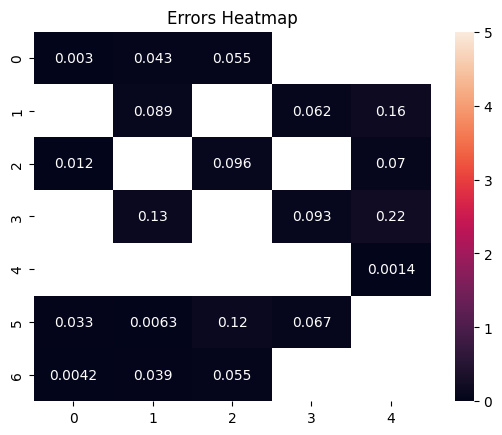

In [274]:
test_BCD_method = HDDA(X=np.array([
                    [2, 3, 2, np.nan, np.nan],
                    [np.nan, 2, np.nan, 4, 3],
                    [3, np.nan, 3, np.nan, 4],
                    [np.nan, 3, np.nan, 4, 3],
                    [np.nan, np.nan, np.nan, np.nan, 2],
                    [1, 4, 3, 4, np.nan],
                    [5, 3, 2, np.nan, np.nan]]),
                r=2, task_name='test_BCD'
    )
test_BCD_method.init_UV('random')
test_BCD_method.BCD(max_iter=10, log_step=10, lambda_reg=0.01, tol=1e-4)
test_BCD_method.show_error_heatmap(max(test_BCD_method.m, test_BCD_method.n))
# test_BCD_method.task.close()

Block coordinate descent method: min f(U,V):  10%|███████                                                                | 1/10 [00:08<01:17,  8.64s/it]

Iteration 1: Training Loss = 0.1517
Validation RMSE: 0.8285


Block coordinate descent method: min f(U,V):  30%|█████████████████████▎                                                 | 3/10 [00:24<00:55,  7.94s/it]

Iteration 3: Training Loss = 0.1395
Validation RMSE: 0.7621


Block coordinate descent method: min f(U,V):  50%|███████████████████████████████████▌                                   | 5/10 [00:39<00:39,  7.84s/it]

Iteration 5: Training Loss = 0.1356
Validation RMSE: 0.7405


Block coordinate descent method: min f(U,V):  60%|██████████████████████████████████████████▌                            | 6/10 [00:56<00:37,  9.37s/it]

Iteration 7: Training Loss = 0.1337
Validation RMSE: 0.7303
Converged at iteration 7
Training Loss = 0.1337
Validation RMSE: 0.7303


(200041, 2)
(200041,)


1         3.88
2         3.42
3         2.74
4         4.22
5         4.37
          ... 
200037    4.35
200038    4.10
200039    3.56
200040    4.28
200041    3.73
Length: 200041, dtype: float64

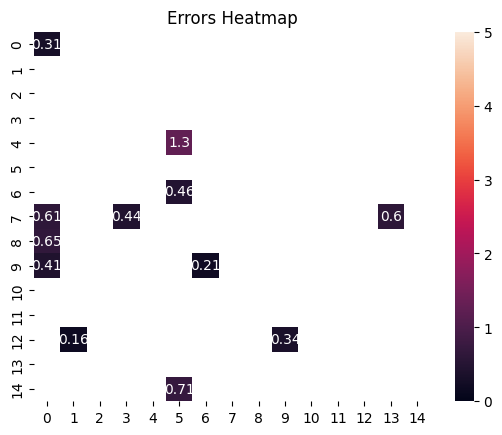

In [271]:
configs = dict(max_iter=10, r=14, tol=0.001, lambda_reg=0.01,  predicts_path='./predicts_BCD.csv')

kaggle_BCD = HDDA(X='./inputX.mat', r=configs['r'], y_true='./ratings_given.csv', task_name='kaggle_BCD')
kaggle_BCD.init_UV('random')


kaggle_BCD.BCD(max_iter=configs['max_iter'], tol=configs['tol'], lambda_reg=configs['lambda_reg'], log_step=2)
kaggle_BCD.show_error_heatmap(15)

kaggle_BCD.test(path='./inputEval.mat', predicts_path=configs['predicts_path'])

# kaggle_BCD.task.close()

In [12]:
# Warning: we have only 10 submissions per 4 hours, use it carefully!
!kaggle competitions submit -c recommendation-systems -f ./predicts_BCD.csv -m "Block coordinate descent method (with sparse implementation) with: 14 latency factors, 7 iterations, 0.01 lambda_reg, 0.7289 rmse on validation"

100%|██████████████████████████████████████| 2.17M/2.17M [00:01<00:00, 1.41MB/s]
Successfully submitted to Recommendation System Project

Here we have 1.0873 rmse on the test set (with 0.7289 rmse on validation set)

# B. Gradient Descent 

In [46]:
@add_to_class(HDDA)
def BCGD(self, lr=0.001, beta=0.5, sigma=0.1, max_iter=100, log_step=2, tol=1e-4, lambda_reg=0.1):
    """Block coordinate descent method"""
    self.task.connect(dict(learning_rate=lr, max_iter=max_iter, 
                           log_step=log_step, tol=tol, latency_factors=self.r, 
                           lambda_reg=lambda_reg, UV_init_strategy=self.UV_strategy))
    logger = Task.get_logger(self.task)

    train_losses = []
    val_losses = []
    prev_error = np.inf

    def armijo_rule(f, x, d, alpha=lr, beta=beta, sigma=sigma):
        """
        Правило Армихо для матричных блоков.

        Параметры:
        - f: функция потерь, возвращающая скалярное значение.
        - x: текущие параметры (матрица).
        - d: направление изменения (градиент, матрица той же размерности, что x).
        - alpha: начальный шаг.
        - beta: коэффициент уменьшения шага.
        - sigma: параметр для условия достаточного убывания.

        Возвращает:
        - alpha: найденный шаг, удовлетворяющий условию Армихо.
        """
        while f(x + alpha * d) > f(x) + sigma * alpha * np.linalg.norm(d, 'fro')**2:
            alpha *= beta
        return alpha
    
    def loss_for_V(V):
        """Функция потерь для V."""
        return np.linalg.norm(self.calc_errors_matrix(self.U, V), 'fro')**2 \
            + lambda_reg * np.linalg.norm(V, 'fro')**2
    
    def loss_for_U(U):
        """Функция потерь для U."""
        return np.linalg.norm(self.calc_errors_matrix(U, self.V), 'fro')**2 \
            + lambda_reg * np.linalg.norm(U, 'fro')**2
    
    for idx in tqdm(range(max_iter), desc='Training'):
        # Update U by fixing V
        error = self.calc_errors_matrix(self.U, self.V)
        U_gradient = -2 * error @ self.V.T + lambda_reg * self.U  # gradient for U 
        alpha_U = armijo_rule(loss_for_U, self.U, -U_gradient)
        self.U -= alpha_U * U_gradient  # update rule for U

        # Update V by fixing U
        error = self.calc_errors_matrix(self.U, self.V)
        V_gradient = -2 * self.U.T @ error + lambda_reg * self.V  # gradient for V 

        alpha_V = armijo_rule(loss_for_V, self.V, -V_gradient)
        self.V -= alpha_V * V_gradient  # update rule for V
        
        error = self.calc_errors_matrix(self.U, self.V)
        loss = HDDA.rmse(error)
        logger.report_scalar('loss', 'train', loss, idx)
        
        if idx % log_step == 0:
            train_losses.append(loss)
            print(f"Iteration {idx}: Loss = {loss:.4f}")
            
            self.predicted_X = self.predict(self.U, self.V) # Final predicted preference matrix
            if hasattr(self, 'val'):
                self.val['predicted'] = self.predicted_X[self.val.iloc[:,0]  - 1, 
                                                         self.val.iloc[:,1] - 1]
                val_loss = HDDA.rmse(np.asarray(self.val['predicted'] - self.val['true']))
                val_losses.append(val_loss)
                logger.report_scalar('loss', 'val', val_loss, idx)

                print("Validation RMSE: ", val_loss, '\n')
            if abs(prev_error - loss) < tol:
                print("Converged.")
                print(f"Iteration {idx}: Loss = {loss:.4f}")
                if hasattr(self, 'val'):
                    print("Validation RMSE: ", val_loss, '\n')
                break
            prev_error = loss
        if np.isnan(loss):
            print("LOSS: ", loss)
            break
    if hasattr(self, 'val'):
        logger.report_single_value('loss/val', val_loss)
        self.finish_val_loss = val_loss

    return self.predicted_X

ClearML Task: created new task id=082f9ffa5c4a480695d840a735a08655
ClearML results page: https://app.clear.ml/projects/520a519c5b09413f9400a52e9dbf3d61/experiments/082f9ffa5c4a480695d840a735a08655/output/log


Training:  27%|███████████████████████████▊                                                                           | 27/100 [00:00<00:00, 132.45it/s]

Iteration 0: Loss = 0.5599
Iteration 5: Loss = 0.1542
Iteration 10: Loss = 0.0802
Iteration 15: Loss = 0.0598
Iteration 20: Loss = 0.0515
Iteration 25: Loss = 0.0483


Training:  60%|█████████████████████████████████████████████████████████████▊                                         | 60/100 [00:00<00:00, 153.52it/s]

Iteration 30: Loss = 0.0470
Iteration 35: Loss = 0.0459
Iteration 40: Loss = 0.0451
Iteration 45: Loss = 0.0443
Iteration 50: Loss = 0.0434
Iteration 55: Loss = 0.0423
Iteration 60: Loss = 0.0413
Iteration 65: Loss = 0.0403


Training:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████▊     | 95/100 [00:00<00:00, 161.97it/s]

Iteration 70: Loss = 0.0394
Iteration 75: Loss = 0.0385
Iteration 80: Loss = 0.0376
Iteration 85: Loss = 0.0369
Iteration 90: Loss = 0.0365
Iteration 95: Loss = 0.0364


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 131.08it/s]


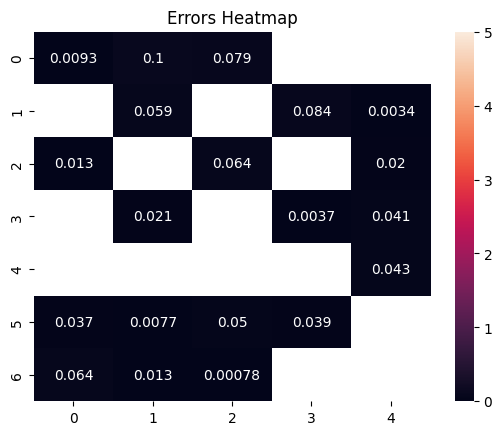

Action failed <400/110: tasks.add_or_update_artifacts/v2.10 (Invalid task status: expected=created, status=stopped)> (task=082f9ffa5c4a480695d840a735a08655, artifacts=[{'key': 'notebook', 'type': 'custom', 'uri': 'https://files.clear.ml/HDDA/test_BCGD.082f9ffa5c4a480695d840a735a08655/artifacts/notebook/project.ipynb', 'content_size': 248427, 'hash': '53e090213e25c0362cc89d163840a6b5c4e37c37ab490050e40104763fe96892', 'timestamp': 1732107212, 'type_data': {'preview': 'See `notebook preview` artifact'}, 'display_data': [('UPDATE', '2024-11-20 12:53:31')]}, {'key': 'notebook preview', 'type': 'custom', 'uri': 'https://files.clear.ml/HDDA/test_BCGD.082f9ffa5c4a480695d840a735a08655/artifacts/notebook%20preview/notebook_082f9ffa5c4a480695d840a735a08655.html', 'content_size': 648483, 'hash': 'e56d6d8a3c0faf6954d7b2e2c6ec2e0f7cefdfd1eed07d137054a655c2a9acb3', 'timestamp': 1732107216, 'type_data': {'preview': 'Click `FILE PATH` link', 'content_type': 'text/html'}, 'display_data': [('UPDATE', '20

In [48]:
test_BCGD_method = HDDA(X=np.array([
                    [2, 3, 2, np.nan, np.nan],
                    [np.nan, 2, np.nan, 4, 3],
                    [3, np.nan, 3, np.nan, 4],
                    [np.nan, 3, np.nan, 4, 3],
                    [np.nan, np.nan, np.nan, np.nan, 2],
                    [1, 4, 3, 4, np.nan],
                    [5, 3, 2, np.nan, np.nan]]),
                r=2, task_name='test_BCGD'
    )
test_BCGD_method.init_UV('random')
test_BCGD_method.BCGD(lr=0.1, beta=0.5, sigma=0.1, max_iter=100, log_step=5, tol=1e-4, lambda_reg=0.1)
test_BCGD_method.show_error_heatmap(7)
test_BCGD_method.task.close()

ClearML Task: created new task id=064042751fd544feb6028fb950c6ccef
ClearML results page: https://app.clear.ml/projects/520a519c5b09413f9400a52e9dbf3d61/experiments/064042751fd544feb6028fb950c6ccef/output/log


Training:   0%|▎                                                                                                        | 1/400 [00:00<02:39,  2.50it/s]

Iteration 0: Loss = 0.5437
Validation RMSE:  2.969386423223089 



Training:   8%|████████                                                                                                | 31/400 [00:03<00:36, 10.12it/s]

Iteration 30: Loss = 0.1719
Validation RMSE:  0.9387717611815375 



Training:  16%|████████████████▍                                                                                       | 63/400 [00:06<00:32, 10.44it/s]

Iteration 60: Loss = 0.1600
Validation RMSE:  0.8739197905025101 



Training:  23%|███████████████████████▋                                                                                | 91/400 [00:09<00:36,  8.57it/s]

Iteration 90: Loss = 0.1555
Validation RMSE:  0.8491968353799394 



Training:  31%|███████████████████████████████▋                                                                       | 123/400 [00:12<00:26, 10.57it/s]

Iteration 120: Loss = 0.1523
Validation RMSE:  0.8318603840148396 



Training:  38%|██████████████████████████████████████▉                                                                | 151/400 [00:16<00:24, 10.20it/s]

Iteration 150: Loss = 0.1498
Validation RMSE:  0.8182937441091395 



Training:  46%|███████████████████████████████████████████████                                                        | 183/400 [00:19<00:20, 10.70it/s]

Iteration 180: Loss = 0.1477
Validation RMSE:  0.8067860133604299 



Training:  53%|██████████████████████████████████████████████████████▊                                                | 213/400 [00:22<00:17, 10.80it/s]

Iteration 210: Loss = 0.1459
Validation RMSE:  0.797106730702089 



Training:  61%|██████████████████████████████████████████████████████████████▌                                        | 243/400 [00:25<00:14, 10.80it/s]

Iteration 240: Loss = 0.1444
Validation RMSE:  0.7887308773476889 



Training:  68%|██████████████████████████████████████████████████████████████████████▎                                | 273/400 [00:27<00:11, 10.92it/s]

Iteration 270: Loss = 0.1430
Validation RMSE:  0.7811604952978121 



Training:  76%|██████████████████████████████████████████████████████████████████████████████                         | 303/400 [00:30<00:09, 10.57it/s]

Iteration 300: Loss = 0.1418
Validation RMSE:  0.774732041147472 



Training:  83%|█████████████████████████████████████████████████████████████████████████████████████▋                 | 333/400 [00:33<00:06, 10.93it/s]

Iteration 330: Loss = 0.1408
Validation RMSE:  0.7689423621476293 



Training:  91%|█████████████████████████████████████████████████████████████████████████████████████████████▍         | 363/400 [00:36<00:03, 10.86it/s]

Iteration 360: Loss = 0.1399
Validation RMSE:  0.7638751811576276 



Training:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 393/400 [00:39<00:00, 10.11it/s]

Iteration 390: Loss = 0.1391
Validation RMSE:  0.7594822681134356 



Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:39<00:00, 10.08it/s]


(200041, 2)
(200041,)


1         4.53
2         3.93
3         4.50
4         4.49
5         4.43
          ... 
200037    4.09
200038    3.37
200039    2.99
200040    4.59
200041    3.41
Length: 200041, dtype: float64

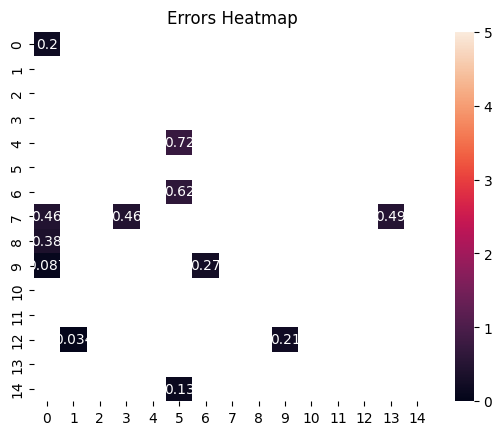

In [81]:
configs = dict(max_iter=300, tol=1e-4, lambda_reg=0.1, log_step=10, r=15)

kaggle_BCGD = HDDA(X='./inputX.mat', r=configs['r'], y_true='./ratings_given.csv', task_name='kaggle_GD')
kaggle_BCGD.init_UV('eye')

kaggle_BCGD.BCGD(lr=0.5, beta=0.1, sigma=0.15, max_iter=400, log_step=30, tol=1e-4, lambda_reg=0.1)

kaggle_BCGD.show_error_heatmap(15)

predicts_path = 'predicts_BCGD.csv'
kaggle_BCGD.test(path='./inputEval.mat', predicts_path=predicts_path)

kaggle_BCGD.task.close()
kaggle_BCGD.test_predicts

In [82]:
# Warning: we have only 10 submissions per 4 hours, use it carefully!
!kaggle competitions submit -c recommendation-systems -f predicts_BCGD.csv -m "Block coordinate gradient descent method with: 15 latency factors, 400 iterations, start 0.5 lr with armijo rule (beta=0.1),  0.7811 rmse on validation"

100%|██████████████████████████████████████| 2.16M/2.16M [00:01<00:00, 1.31MB/s]
400 - Bad Request - Submission not allowed:  Your team has used its daily Submission allowance (10) today, please try again tomorrow UTC (10 hours from now).


Here we have 0.8626 rmse on the test set (with 0.7539 rmse on validation set)

# C. rank 1 factorization

In [ ]:
import cupy as np

In [ ]:
# Определяем матрицу предпочтений с NaN для неизвестных рейтингов
X = np.array([[2, 3, 2, np.nan, np.nan],
              [np.nan, 2, np.nan, 4, 3],
              [3, np.nan, 3, np.nan, 4],
              [np.nan, 3, np.nan, 4, 3],
              [np.nan, np.nan, np.nan, np.nan, 2],
              [1, 4, 3, 4, np.nan]])

In [ ]:
def matrix_factorization(R, K, steps=5000, alpha=0.002, beta=0.02):
    num_users, num_items = R.shape
    # Инициализируем матрицы признаков пользователей и фильмов
    P = np.random.normal(scale=1./K, size=(num_users, K))
    Q = np.random.normal(scale=1./K, size=(num_items, K))

    # Выполняем оптимизацию
    for step in range(steps):
        for i in range(num_users):
            for j in range(num_items):
                if not np.isnan(R[i][j]):
                    eij = R[i][j] - np.dot(P[i,:], Q[j,:])  # Ошибка
                    # Обновляем матрицы P и Q
                    P[i,:] += alpha * (eij * Q[j,:] - beta * P[i,:])
                    Q[j,:] += alpha * (eij * P[i,:] - beta * Q[j,:])

    return P, Q

In [ ]:
K = 3  # Количество латентных факторов
P, Q = matrix_factorization(X.copy(), K)

# Восстанавливаем предсказанную матрицу рейтингов
predicted_ratings = np.dot(P, Q.T)  # Транспонируем Q для корректного умножения

# Выводим предсказанные рейтинги для всех пользователей
print("Предсказанные рейтинги для всех пользователей:")
print(predicted_ratings)

Предсказанные рейтинги для всех пользователей:
[[ 1.97330477  2.99890441  1.95767638  2.83557736  2.62798401]
 [-0.1595868   2.05939973  1.74877955  3.97425509  2.92559039]
 [ 2.95079508  4.60001816  3.0206594   3.90231631  3.93706704]
 [ 1.51029481  2.94678933  2.04081471  3.94571112  3.05991129]
 [ 0.91475315  2.07650848  1.47333034  1.96276392  1.98825007]
 [ 1.04540651  3.92674175  2.96594743  3.99728145  4.09378662]]


# Hyperparameters tuning

In [10]:
X_rank = np.linalg.matrix_rank(kaggle_BCD.X)
X_rank

array(3952)

In [5]:
def objective(trial: optuna.Trial):
    rank = trial.suggest_int("rank", 0, X_rank)
    init_UV = trial.suggest_categorical("init_UV", ["random"])

    configs = dict(max_iter=6, r=rank)

    kaggle_NMF = HDDA(X='./inputX.mat', r=configs['r'], y_true='./ratings_given.csv', 
                      task_name='kaggle_NMF_search_optimal_rank')
    kaggle_NMF.init_UV(init_UV)
    kaggle_NMF.NMF(max_iter=configs['max_iter'], log_step=5)
    return kaggle_NMF.finish_val_loss
    

In [20]:
study = optuna.create_study(storage="sqlite:///db.sqlite3",
                            study_name="hdda-project-recommendation_systems",
                            direction="minimize", 
                            load_if_exists=True)

study.optimize(objective, n_trials=1000, show_progress_bar=True)

[I 2024-11-18 22:56:34,958] Using an existing study with name 'hdda-project-recommendation_systems' instead of creating a new one.


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 0: Loss = 1051.5424
RMSE on val:  1.1755371566767199 



Training: 100%|████████████████████████████| 6/6 [00:04<00:00,  1.22it/s]


Iteration 5: Loss = 1050.6707
RMSE on val:  1.1745649576667296 

[I 2024-11-18 22:56:41,365] Trial 162 finished with value: 1.1745649576667296 and parameters: {'rank': 1502, 'init_UV': 'random'}. Best is trial 20 with value: 1.1736211707480357.


Iteration 0: Loss = 1051.0987


RMSE on val:  1.1750435048456551 



Iteration 5: Loss = 1050.2252


Training: 100%|████████████████████████████| 6/6 [00:09<00:00,  1.60s/it]


RMSE on val:  1.1740751993418144 

[I 2024-11-18 22:56:52,245] Trial 163 finished with value: 1.1740751993418144 and parameters: {'rank': 2723, 'init_UV': 'random'}. Best is trial 20 with value: 1.1736211707480357.


Iteration 0: Loss = 1051.3948
RMSE on val:  1.175375910010808 



Training: 100%|████████████████████████████| 6/6 [00:05<00:00,  1.12it/s]


Iteration 5: Loss = 1050.5268
RMSE on val:  1.1744065607949794 

[I 2024-11-18 22:56:58,906] Trial 164 finished with value: 1.1744065607949794 and parameters: {'rank': 1618, 'init_UV': 'random'}. Best is trial 20 with value: 1.1736211707480357.


Iteration 0: Loss = 1051.5044


RMSE on val:  1.1754999879108754 



Iteration 5: Loss = 1050.6410


Training: 100%|████████████████████████████| 6/6 [00:09<00:00,  1.59s/it]


RMSE on val:  1.1745315752977916 

[I 2024-11-18 22:57:09,732] Trial 165 finished with value: 1.1745315752977916 and parameters: {'rank': 2710, 'init_UV': 'random'}. Best is trial 20 with value: 1.1736211707480357.


Iteration 0: Loss = 1051.8895
RMSE on val:  1.1759265407315496 



Training: 100%|████████████████████████████| 6/6 [00:04<00:00,  1.32it/s]


Iteration 5: Loss = 1051.0055
RMSE on val:  1.1749375571981278 

[I 2024-11-18 22:57:15,534] Trial 166 finished with value: 1.1749375571981278 and parameters: {'rank': 1406, 'init_UV': 'random'}. Best is trial 20 with value: 1.1736211707480357.


Iteration 0: Loss = 1051.4262


RMSE on val:  1.175412582980781 



Iteration 5: Loss = 1050.5558


Training: 100%|████████████████████████████| 6/6 [00:09<00:00,  1.53s/it]


RMSE on val:  1.17443897571325 

[I 2024-11-18 22:57:25,951] Trial 167 finished with value: 1.17443897571325 and parameters: {'rank': 2591, 'init_UV': 'random'}. Best is trial 20 with value: 1.1736211707480357.


Iteration 0: Loss = 1051.3789
RMSE on val:  1.1753547004219285 



Training: 100%|████████████████████████████| 6/6 [00:05<00:00,  1.02it/s]


Iteration 5: Loss = 1050.4911
RMSE on val:  1.1743677031511626 

[I 2024-11-18 22:57:33,185] Trial 168 finished with value: 1.1743677031511626 and parameters: {'rank': 1760, 'init_UV': 'random'}. Best is trial 20 with value: 1.1736211707480357.


Iteration 0: Loss = 1051.7648


RMSE on val:  1.1757934190645454 



Training:  83%|███████████████████████▎    | 5/6 [00:14<00:02,  2.84s/it]


[W 2024-11-18 22:57:48,740] Trial 169 failed with parameters: {'rank': 3859, 'init_UV': 'random'} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/prog3/.cache/pypoetry/virtualenvs/hdda-ogT78WGF-py3.10/lib/python3.10/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_618151/909467058.py", line 10, in objective
    kaggle_NMF.NMF(max_iter=configs['max_iter'], log_step=5)
  File "/tmp/ipykernel_618151/4174593209.py", line 31, in NMF
    logger.report_scalar('loss', 'train', loss, idx)
  File "/home/prog3/.cache/pypoetry/virtualenvs/hdda-ogT78WGF-py3.10/lib/python3.10/site-packages/clearml/logger.py", line 179, in report_scalar
    return self._task._reporter.report_scalar(title=title, series=series, value=float(value), iter=iteration)
KeyboardInterrupt
[W 2024-11-18 22:57:48,741] Trial 169 failed with value None.


KeyboardInterrupt: 

In [37]:
Task.get_task(task_name='kaggle_NMF_search_optimal_rank').close()

2 task found when searching for `{'task_name': 'kaggle_NMF_search_optimal_rank', 'include_archived': True}`
Selected task `kaggle_NMF_search_optimal_rank` (id=a3c5b167c7ac48898b94b3c608e977ee)


: 

In [21]:
trial = study.best_trial
best_rank = trial.params['rank']
best_rank

2718